In [63]:
import time, math, copy, numpy as np, torch
import torch.nn as nn
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

from datastructures import *
from training import *
from models import *


device = 'cuda' if torch.cuda.is_available() else 'cpu'

def huber_loss(pred, target, delta=0.0):
    if delta == 0.0:
        return 0.5 * (pred - target) ** 2
    err = pred - target
    abs_err = torch.abs(err)
    quad = torch.minimum(abs_err, torch.tensor(delta, device=pred.device))
    return 0.5 * quad**2 + delta * (abs_err - quad)

def build_model(n_markers: int):
    # Swap this for your other model if you like.
    return PureSAGECurvature(
        n_markers=n_markers,
        hidden_dim=128,
        num_layers=4,
        dropout=0.1,
        residual=True,
        norm='layer'
    )

@torch.no_grad()
def predict(model, g):
    yhat, _ = model(g.x.to(device), g.edge_index.to(device))
    return yhat.detach().cpu().numpy()

def train_one(model, graph, epochs=500, lr=3e-3, wd=0.0, huber_delta=0.0, clip_grad=2.0):
    """Full-batch train on a single graph for a fixed epoch budget."""
    g = copy.deepcopy(graph).to(device)
    model = model.to(device).train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    best = (math.inf, None)  # by MAE
    for ep in range(1, epochs + 1):
        yhat, _ = model(g.x, g.edge_index)
        loss = huber_loss(yhat, g.y, huber_delta).mean()
        opt.zero_grad(set_to_none=True)
        loss.backward()
        if clip_grad is not None:
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        opt.step()

        with torch.no_grad():
            mae = torch.mean(torch.abs(yhat - g.y)).item()
        if mae < best[0]:
            best = (mae, {k: v.detach().cpu().clone() for k, v in model.state_dict().items()})

    if best[1] is not None:
        model.load_state_dict(best[1])
    model.eval()
    return model

def overfit_one_graph_lbfgs(
    model,
    graph,
    device=None,
    outer_steps=60,           # number of optimizer.step(closure) calls
    lr=0.5,                   # LBFGS step size (try 0.2–1.0)
    max_iter=20,              # internal line-search evaluations per step
    history_size=100,
    tol_change=1e-12,
):
    """
    Full-batch LBFGS on a single PyG graph with a deterministic closure.
    - Runs model.eval() inside the closure to disable dropout/BN updates.
    - Uses MSE (smooth) for LBFGS friendliness.
    - RETURNS (model, history) where history has 'loss' and 'mae' lists.
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    g = copy.deepcopy(graph).to(device)
    model = model.to(device)

    opt = torch.optim.LBFGS(
        model.parameters(),
        lr=lr,
        max_iter=max_iter,
        history_size=history_size,
        line_search_fn="strong_wolfe",
        tolerance_change=tol_change,
    )

    best = (math.inf, None)
    history = {"loss": [], "mae": []}

    def closure():
        opt.zero_grad(set_to_none=True)
        # Deterministic forward pass for line search:
        model.eval()  # disables dropout; BN stats frozen
        yhat, _ = model(g.x, g.edge_index)
        loss = F.mse_loss(yhat, g.y)
        loss.backward()
        return loss

    for t in range(outer_steps):
        loss = opt.step(closure)
        with torch.no_grad():
            model.eval()
            yhat, _ = model(g.x, g.edge_index)
            mae = torch.mean(torch.abs(yhat - g.y)).item()
        history["loss"].append(loss.item())
        history["mae"].append(mae)
        if mae < best[0]:
            best = (mae, {k: v.detach().cpu().clone() for k, v in model.state_dict().items()})
        # tiny improvement → stop
        if t > 5 and abs(history["loss"][-1] - history["loss"][-2]) < 1e-12:
            break

    if best[1] is not None:
        model.load_state_dict(best[1])
    model.eval()
    return model, history


def layout_xy(graph, layout="spring", seed=0):
    """Get a 2D layout for consistent plotting."""
    G = to_networkx(graph, to_undirected=True)
    import networkx as nx
    if layout == "spring":
        pos = nx.spring_layout(G, seed=seed)
    elif layout == "spectral":
        pos = nx.spectral_layout(G)
    else:
        raise ValueError("layout must be 'spring' or 'spectral'")
    N = graph.x.size(0)
    return np.array([pos[i] for i in range(N)])

def plot_graph_triptych(xy, y_true, y_pred, title_prefix="", node_size=15):
    """Plot true / pred / residual with shared layout."""
    res = y_pred - y_true
    vmin_y, vmax_y = np.percentile(np.concatenate([y_true, y_pred]), [1, 99])
    vmin_r, vmax_r = np.percentile(res, [1, 99])

    fig, axes = plt.subplots(1, 3, figsize=(13, 3.6), constrained_layout=True)
    panels = [
        ("True y", y_true, "viridis", vmin_y, vmax_y),
        ("Pred ŷ", y_pred, "viridis", vmin_y, vmax_y),
        ("Residual ŷ−y", res, "coolwarm", vmin_r, vmax_r),
    ]
    for ax, (lbl, vals, cmap, vmin, vmax) in zip(axes, panels):
        sc = ax.scatter(xy[:,0], xy[:,1], c=vals, s=node_size, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(f"{title_prefix} — {lbl}")
        ax.set_xticks([]); ax.set_yticks([])
        fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    plt.show()


In [64]:
data_dir = "training_data"
graphs = load_dir_to_graphs(data_dir)
print(f"Loaded {len(graphs)} organoids.")


g_train, g_val = split_graphs(graphs, val_frac=0.2, seed=42)
print(f"Split -> train: {len(g_train)} | val: {len(g_val)}")

Loaded 1000 organoids.
Split -> train: 800 | val: 200


In [65]:
g0 = g_train[0]
n_markers = int(g0.x.size(1))

def build_model():
    from models import PureSAGECurvature
    return PureSAGECurvature(
        n_markers=n_markers,
        hidden_dim=128,
        num_layers=4,
        dropout=0.0,      # IMPORTANT: keep 0.0 for LBFGS tests
        residual=True,
        norm='layer'
    )

# AdamW baseline (full-batch)
def overfit_one_graph_adam(model, graph, device, epochs=2000, lr=3e-3, wd=0.0):
    g = copy.deepcopy(graph).to(device)
    model = model.to(device).train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    best = (math.inf, None); hist = {"loss": [], "mae": []}
    for ep in range(1, epochs+1):
        yhat, _ = model(g.x, g.edge_index)
        loss = F.mse_loss(yhat, g.y)
        opt.zero_grad(set_to_none=True); loss.backward()
        # avoid clipping if you want max speed; if used, keep it generous
        # nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()
        with torch.no_grad():
            mae = torch.mean(torch.abs(yhat - g.y)).item()
        hist["loss"].append(loss.item()); hist["mae"].append(mae)
        if mae < best[0]:
            best = (mae, {k: v.detach().cpu().clone() for k, v in model.state_dict().items()})
    if best[1] is not None:
        model.load_state_dict(best[1])
    model.eval(); return model, hist

# Run both
adam_model, adam_hist = overfit_one_graph_adam(build_model(), g0, device=device, epochs=10000, lr=1e-3)
lbfgs_model, lbfgs_hist = overfit_one_graph_lbfgs(build_model(), g0, device=device,
                                                  outer_steps=200, lr=0.1, max_iter=100)


AdamW MSE: 0.00032422220101580024
LBFGS  MSE: 0.0005041210097260773


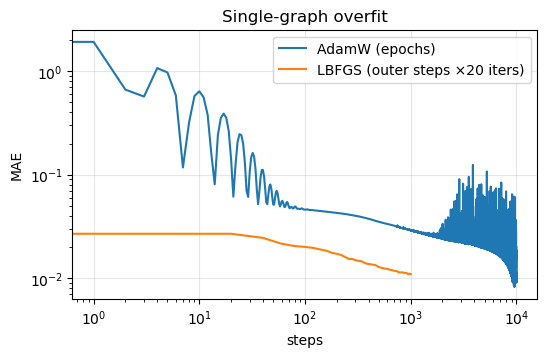

In [66]:

# Compare final errors
import numpy as np
def mse(model, g):
    with torch.no_grad():
        yp, _ = model(g.x.to(device), g.edge_index.to(device))
        return float(torch.mean((yp.cpu() - g.y)**2))
print("AdamW MSE:", mse(adam_model, g0))
print("LBFGS  MSE:", mse(lbfgs_model, g0))

# Plot MAE vs step
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3.5))
plt.plot(adam_hist["mae"], label="AdamW (epochs)")
plt.plot(range(0, len(lbfgs_hist["mae"])*20, 20), lbfgs_hist["mae"], label="LBFGS (outer steps ×20 iters)")
plt.xlabel("steps"); plt.ylabel("MAE"); plt.title("Single-graph overfit")
plt.yscale('log')
plt.xscale('log')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()


In [67]:
# ---- choose a single organoid to overfit ----
g0 = g_train[0]
n_markers = int(g0.x.size(1))
xy = layout_xy(g0, layout="spring", seed=0)
y_true = g0.y.detach().cpu().numpy()

# ---- epoch budgets to try ----
# epoch_grid = [1e2, 5e2, 1e3, 5e3, 1e4]  # adjust as you like
epoch_grid = [1e2, 5e2, 1e3]  # adjust as you like

results = []  # list of dicts: {'epochs', 'mse', 'mae', 'yhat'}
for E in epoch_grid:
    m = build_model(n_markers)
    # m = train_one(m, g0, epochs=int(E), lr=3e-3, wd=0.0, huber_delta=0.0)
    m = overfit_one_graph_lbfgs(m, g0, device=device, max_iter=int(E))
    yhat = predict(m, g0)
    mse = float(np.mean((yhat - y_true) ** 2))
    mae = float(np.mean(np.abs(yhat - y_true)))
    results.append({"epochs": E, "mse": mse, "mae": mae, "yhat": yhat, "model": m})
    print(f"epochs={E:6f}  MSE={mse:.6f}  MAE={mae:.6f}")

# ---- visualize each epoch budget ----
for r in results:
    plot_graph_triptych(xy, y_true, r["yhat"], title_prefix=f"{r['epochs']} epochs")


TypeError: build_model() takes 0 positional arguments but 1 was given

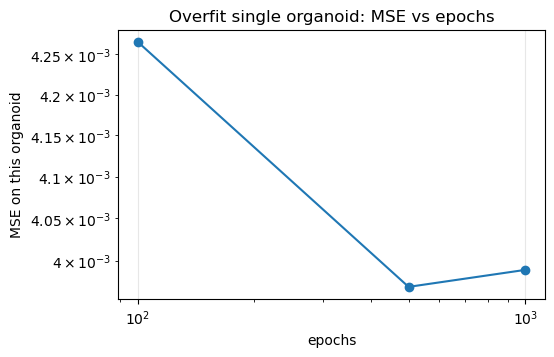

In [ ]:

# ---- MSE vs epochs curve ----
plt.figure(figsize=(5.5,3.5))
plt.plot([r["epochs"] for r in results], [r["mse"] for r in results], marker='o')
plt.xlabel("epochs")
plt.ylabel("MSE on this organoid")
plt.title("Overfit single organoid: MSE vs epochs")
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.show()
